In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import pandas

In [3]:
hist_kw = dict(bins=60, normed=True, alpha=0.5)

# Stability. Confidence Intervals

Compare ROC curve stability for simple Tree and for any ensemble method. Do they have different confidence intervals for ROC curves and AUC indeed?

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
data = pandas.read_csv('datasets/training.csv')

In [5]:
data.columns

Index([u'id', u'LifeTime', u'dira', u'FlightDistance', u'FlightDistanceError',
       u'IP', u'IPSig', u'VertexChi2', u'pt', u'DOCAone', u'DOCAtwo',
       u'DOCAthree', u'IP_p0p2', u'IP_p1p2', u'isolationa', u'isolationb',
       u'isolationc', u'isolationd', u'isolatione', u'isolationf', u'iso',
       u'CDF1', u'CDF2', u'CDF3', u'ISO_SumBDT', u'p0_IsoBDT', u'p1_IsoBDT',
       u'p2_IsoBDT', u'p0_track_Chi2Dof', u'p1_track_Chi2Dof',
       u'p2_track_Chi2Dof', u'p0_IP', u'p1_IP', u'p2_IP', u'p0_IPSig',
       u'p1_IPSig', u'p2_IPSig', u'p0_pt', u'p1_pt', u'p2_pt', u'p0_p',
       u'p1_p', u'p2_p', u'p0_eta', u'p1_eta', u'p2_eta', u'SPDhits',
       u'production', u'signal', u'mass', u'min_ANNmuon'],
      dtype='object')

In [6]:
variables = list(set(data.columns) - {'id', 'min_ANNmuon', 'mass', 'signal', 'production'})

### Define function to compute CL for ROC curve and AUC

In [8]:
from sklearn import clone
def compute_CL(models, x_fpr, iterations=30):
    result = {}
    for name, model in models.items():
        aucs = []
        rocs = []
        # repeat training 30 times on different training sample
        for iterations in range(30):
            # divide randomly into train - test samples
            train_ind, test_ind = train_test_split(range(len(data)))
            train_data = data.ix[train_ind, :]
            test_data = data.ix[test_ind, :]
            training_model = clone(model)
            training_model.fit(train_data[variables], train_data.signal.values)
            probs = training_model.predict_proba(test_data[variables])[:, 1]
            fpr, tpr, _ = roc_curve(test_data.signal.values, probs)
            # linear interpolation for roc curve
            rocs.append(numpy.interp(x_fpr, fpr, tpr))
            aucs.append(roc_auc_score(test_data.signal.values, probs))
        mean_roc = numpy.mean(rocs, axis=0)
        std_roc = numpy.std(rocs, axis=0)
        print name, numpy.mean(aucs), numpy.std(aucs)
        result[name] = (mean_roc, std_roc)
    return result
        
def plot_roc_CL(x_fpr, mean_roc, std_roc, r_xlim=(0, 1), r_ylim=(0, 1)):
    figsize(10, 8)
    plot(x_fpr, mean_roc, label='mean', color='r')
    plot(x_fpr, mean_roc + std_roc, label='+', color='b')
    plot(x_fpr, mean_roc - std_roc, label='-', color='g')
    legend()
    xlim(r_xlim[0], r_xlim[1])
    ylim(r_ylim[0], r_ylim[1])

In [9]:
fpr_points = numpy.linspace(0, 1, 100)

### Confidence ROC curve intervals for simple tree 

In [10]:
from sklearn.tree import DecisionTreeClassifier
simple_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, max_features=8)

### Confidence ROC curve intervals for simple tree 

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
simple_gb = GradientBoostingClassifier(max_depth=8, learning_rate=0.05, n_estimators=100, 
                                         min_samples_leaf=50, max_features=8, subsample=0.7)

In [12]:
# compute results
result = compute_CL({'tree': simple_tree, 'GB': simple_gb}, fpr_points)

tree 0.89205338513 0.00566106536487
GB 0.946455237287 0.00186825032873


#### ROC CL for tree

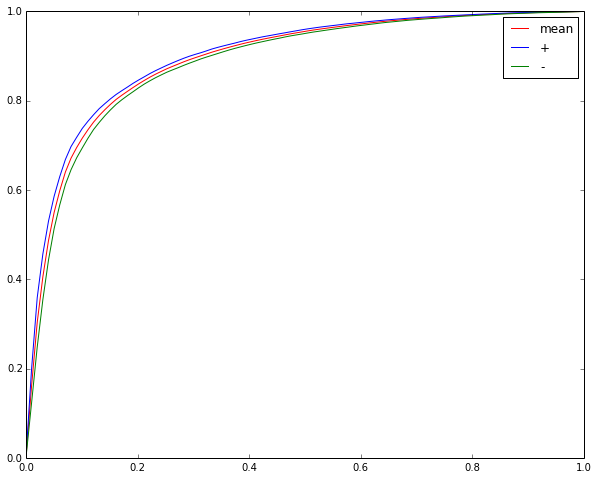

In [13]:
plot_roc_CL(fpr_points, result['tree'][0], result['tree'][1])

#### ROC CL for GB

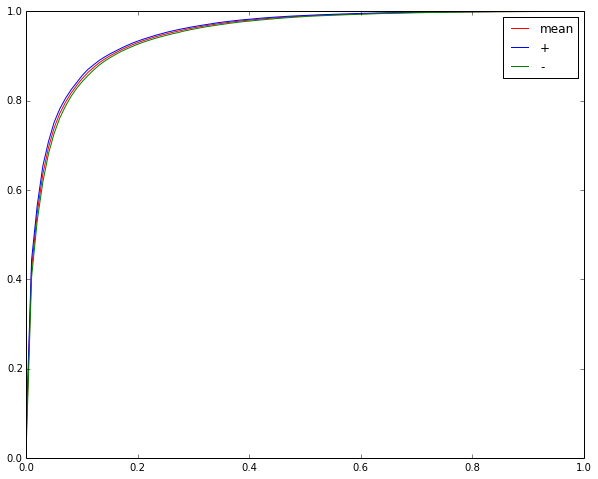

In [14]:
plot_roc_CL(fpr_points, result['GB'][0], result['GB'][1])

# Flatness models

Compare flatness models (uGBFL and knnAdaLoss), trained on the mass, with any ensemble model (1) trained on the mass and 2) without it).

* Do they have comparable qualities? 
* What about CvM values? (check on `data_correlation.csv`)
* Do you see non-flatness? (plot for several thresholds the local efficiency in the mass bin)

**Use**:
    
     from hep_ml.gradientboosting import UGradientBoostingClassifier
     from hep_ml.losses import BinFlatnessLossFunction, 

**Note**:

* `UGradientBoostingClassifier` has parameter `train_features`, in which `mass` (or another flatness vars) should be absent. It use `pandas.DataFrame` as input for fit.
* Loss functions have `uniform_features` parameter, set it to `['mass']`, and uniform_label, for us it should be zero label (bck)

In [15]:
data = pandas.read_csv('datasets/training.csv')
data_correlation = pandas.read_csv('datasets/check_correlation.csv')
train_features = list(set(data_correlation.columns) - {'id', 'signal', 'mass', 'SPDhits'})

In [16]:
# Divide train on train, test
train_index, test_index = train_test_split(range(len(data)))
train = data.iloc[train_index, :]
test = data.iloc[test_index, :]

### Compute the order of non-correlated model

In [17]:
from utils import compute_cvm
compute_cvm(data_correlation.mass.values, numpy.random.random(size=len(data_correlation)))

0.00062251845789051193

In [18]:
# define function to test model on cvm and calculate quality
def test_model(model, features):
    model_cvm = model.predict_proba(data_correlation[features])[:, 1]
    model_corr = compute_cvm(data_correlation.mass.values, model_cvm)
    print 'Correlation', model_corr
    print 'AUC', roc_auc_score(test.signal.values, model.predict_proba(test[features])[:, 1])

### Standard model, trained on the mass

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
gb_mass = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, min_samples_leaf=50, subsample=0.5, 
                                     max_features=8, max_depth=6)
gb_mass.fit(train[train_features + ['mass']], train['signal'].values)
test_model(gb_mass, train_features + ['mass'])

Correlation 0.023118372055
AUC 0.997297837307


###Standard model, trained without mass

In [21]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, min_samples_leaf=50, subsample=0.5, 
                                max_features=8, max_depth=6)
gb.fit(train[train_features], train['signal'].values)
test_model(gb, train_features)

Correlation 0.00125954803664
AUC 0.92156895567


### FlatnessLoss with bins approximation for CvM computations

In [22]:
from hep_ml import gradientboosting, losses
from hep_ml.gradientboosting import UGradientBoostingClassifier
# define loss function, here fl_coefficient is flatness coefficient
loss=losses.BinFlatnessLossFunction(uniform_features=['mass'], uniform_label=0, n_bins=20, fl_coefficient=5)
ugb_flatness_loss = UGradientBoostingClassifier(loss=loss, train_features=train_features, 
                                                subsample=0.5, max_features=8, min_samples_leaf=50, max_depth=6)
ugb_flatness_loss.fit(train, train.signal.values)
test_model(ugb_flatness_loss, train_features)

Correlation 0.00103128690351
AUC 0.936661911494


### FlatnessLoss with knn approximation for CvM computations

In [23]:
# define loss function
loss=losses.KnnFlatnessLossFunction(uniform_features=['mass'], uniform_label=0, n_neighbours=50, fl_coefficient=4)
ugb_flatness_loss_knn = UGradientBoostingClassifier(loss=loss, train_features=train_features, 
                                                subsample=0.5, max_features=8, min_samples_leaf=50, max_depth=6)
ugb_flatness_loss_knn.fit(train, train.signal.values)
test_model(ugb_flatness_loss_knn, train_features)

Correlation 0.000929947531336
AUC 0.936588225166


### knnAdaLoss

In [24]:
# define loss function
loss=gradientboosting.KnnAdaLossFunction(uniform_features=['mass'], uniform_label=0, knn=10)
ugb_knn_loss = UGradientBoostingClassifier(loss=loss, train_features=train_features, 
                                                subsample=0.5, max_features=8, min_samples_leaf=50, max_depth=6)
ugb_knn_loss.fit(train, train.signal.values)
test_model(ugb_knn_loss, train_features)

Correlation 0.0010084743331
AUC 0.934379515814


## Compare efficiencies

In [25]:
def plot_efficiencies(model, features, mass_bins=20):
    figsize(8, 5)
    probs = model.predict_proba(data_correlation[features])[:, 1]
    m_b = data_correlation.mass.values
    mass_p = numpy.percentile(m_b, numpy.linspace(0, 100, mass_bins + 1))
    mass_centers = mass_p[:-1] + (mass_p[1:] - mass_p[:-1]) / 2. 
    bins_index = numpy.searchsorted(mass_p[1:-1], m_b)

    for threshold in numpy.percentile(probs, [20, 40, 60, 80]):
        eff_bins = numpy.bincount(bins_index, weights=(probs > threshold) * 1., minlength=len(mass_centers))
        plot(mass_centers, eff_bins, label=threshold)
    legend()

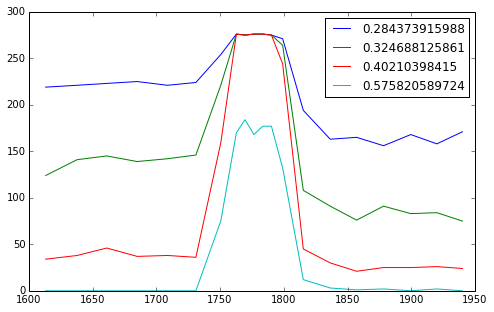

In [26]:
plot_efficiencies(gb_mass, train_features + ['mass'])

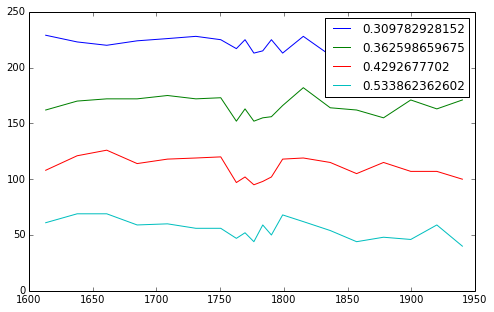

In [27]:
plot_efficiencies(gb, train_features)

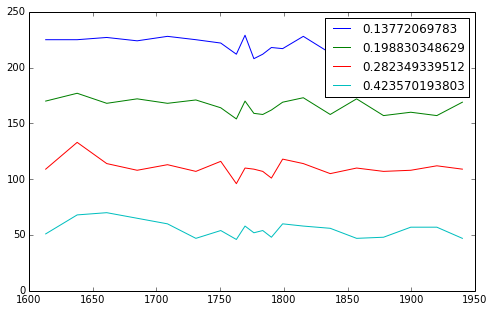

In [28]:
plot_efficiencies(ugb_flatness_loss, train_features + ['mass'])

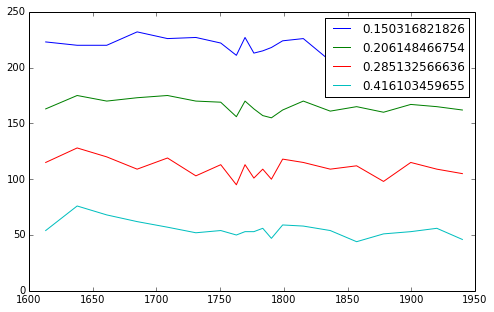

In [29]:
plot_efficiencies(ugb_flatness_loss_knn, train_features + ['mass'])

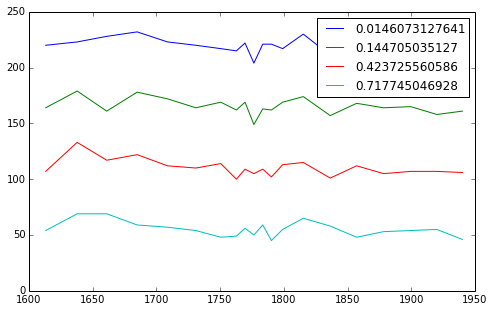

In [30]:
plot_efficiencies(ugb_knn_loss, train_features + ['mass'])

## Can you combine several models to improve AUC 

Remember that the correlation shoud be less than 0.002 as in the kaggle competition.

In [31]:
def test_combination_model(models, features, coeffs):
    probs = numpy.zeros(len(test))
    model_cvm = numpy.zeros(len(data_correlation))
    for model, feat, coeff in zip(models, features, coeffs):        
        model_cvm += coeff * model.predict_proba(data_correlation[feat])[:, 1]
        probs += coeff * model.predict_proba(test[feat])[:, 1]
    model_corr = compute_cvm(data_correlation.mass.values, model_cvm)
    print 'Correlation', model_corr
    print 'AUC', roc_auc_score(test.signal.values, probs)

In [32]:
test_combination_model([ugb_knn_loss, ugb_flatness_loss, ugb_flatness_loss_knn], [train_features]*3, [0.2, 0.4, 0.4])

Correlation 0.0010805530087
AUC 0.937744551913
